# Sector Coupling

:::{note}
If you have not yet set up Python on your computer, you can execute this tutorial in your browser via [Google Colab](https://colab.research.google.com/). Click on the rocket in the top right corner and launch "Colab". If that doesn't work download the `.ipynb` file and import it in [Google Colab](https://colab.research.google.com/).
Then install the following packages by executing the following command in a Jupyter cell at the top of the notebook.

```sh
!pip install -q pypsa pandas numpy matplotlib highspy "plotly<6"
```
:::

In [1]:
import pypsa
import pandas as pd
import numpy as np
import plotly.io as pio
import plotly.offline as py
import matplotlib.pyplot as plt

def annuity(r, n):
    return r / (1.0 - 1.0 / (1.0 + r) ** n)

pd.options.plotting.backend = "plotly"

SOLVER = "highs" # or 'gurobi'

## Previously

To explore sector-coupling options with PyPSA, let's load the capacity expansion model we built for the electricity system and add sector-coupling technologies and demands on top. 

In [2]:
url = "https://tubcloud.tu-berlin.de/s/Rz4iDEQq8DwBd6R/download/electricity-network.nc"
n = pypsa.Network(url)
n

INFO:pypsa.network.io:Retrieving network data from https://tubcloud.tu-berlin.de/s/Rz4iDEQq8DwBd6R/download/electricity-network.nc.
INFO:pypsa.network.io:Imported network 'Unnamed Network' has buses, carriers, generators, global_constraints, loads, storage_units


PyPSA Network 'Unnamed Network'
-------------------------------
Components:
 - Bus: 1
 - Carrier: 6
 - Generator: 3
 - GlobalConstraint: 1
 - Load: 1
 - StorageUnit: 2
Snapshots: 2920

## Hydrogen Production

The following example shows how to model the components of hydrogen storage separately, i.e. electrolysis, fuel cell and storage.

First, let's remove the simplified hydrogen storage representation:

In [3]:
n.remove("StorageUnit", "hydrogen storage underground")

Add a separate `Bus` for the hydrogen energy carrier:

In [4]:
n.add("Bus", "hydrogen", carrier="hydrogen");

Add a `Link` for the hydrogen electrolysis:

In [5]:
n.add(
    "Link",
    "electrolysis",
    bus0="electricity",
    bus1="hydrogen",
    carrier="electrolysis",
    p_nom_extendable=True,
    efficiency=0.65,
    capital_cost=annuity(0.07, 25) * 1_500_000,  # €/MW/a
)

Index(['electrolysis'], dtype='object')

Add a `Link` for the fuel cell which reconverts hydrogen to electricity:

In [6]:
n.add(
    "Link",
    "fuel cell",
    bus0="hydrogen",
    bus1="electricity",
    carrier="fuel cell",
    p_nom_extendable=True,
    efficiency=0.45,
    capital_cost=annuity(0.07, 25) * 550_000,  # €/MW/a
);

Add a `Store` for the hydrogen storage:

In [7]:
n.add(
    "Store",
    "hydrogen storage",
    bus="hydrogen",
    carrier="hydrogen storage",
    capital_cost=annuity(0.07, 100) * 2_000,  # €/MWh/a
    e_nom_extendable=True,
    e_cyclic=True,  # cyclic state of charge
);

We can also add a hydrogen demand to the hydrogen bus.

In the example below, we add a constant hydrogen demand the size of the electricity demand.

In [8]:
p_set = n.loads_t.p_set["demand"].mean()
p_set

np.float64(7564.622045662099)

In [9]:
n.add("Load", "hydrogen demand", bus="hydrogen", carrier="hydrogen", p_set=p_set);  # MW

Add new `Carrier` extensions (only used for plotting):

In [10]:
n.add(
    "Carrier",
    ["hydrogen", "electrolysis", "fuel cell", "hydrogen storage", "hydrogen demand"],
    color=["cyan", "magenta", "orange", "purple", "cyan"],
);

When we now optimize the model with additional hydrogen demand...

In [11]:
n.optimize(solver_name=SOLVER, log_to_console=False)

INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 11/11 [00:00<00:00, 153.25it/s]
INFO:linopy.io: Writing time: 0.49s


Running HiGHS 1.11.0 (git hash: 364c83a): Copyright (c) 2025 HiGHS under MIT licence terms


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 29207 primals, 64248 duals
Objective: 1.24e+10
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-ext-e-lower, Store-ext-e-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.


('ok', 'optimal')

...we can see the individual sizing of the electrolyser, fuel cell and hydrogen storage:

In [12]:
n.statistics.optimal_capacity().div(1e3).round(2)

component    carrier         
Generator    solar                 64.22
             wind                  58.56
Link         electrolysis          20.09
             fuel cell              9.50
StorageUnit  battery storage       13.85
Store        hydrogen storage    4596.07
dtype: float64

Furthermore, we might want to explore the storage state of charge of the hydrogen storage and the balancing patterns:

In [13]:
n.stores_t.e.div(1e6).plot()  # TWh

The energy balance we can now inspect by different bus carriers:

In [14]:
n.statistics.energy_balance.iplot.area(bus_carrier="electricity")

In [15]:
n.statistics.energy_balance.iplot.area(bus_carrier="hydrogen")

## Heat Demand

For modelling simple heating systems, we create another bus and connect a load with the heat demand time series to it.

In [16]:
n.add("Bus", "heat", carrier="heat");

In [17]:
url = "https://tubcloud.tu-berlin.de/s/8KWqTAHEM9m8dFj/download/heat-demand.csv"
p_set = pd.read_csv(url, index_col=0, parse_dates=True).squeeze()[::3]

In [18]:
n.add("Load", "heat demand", carrier="heat", bus="heat", p_set=p_set);

In [19]:
n.loads_t.p_set.div(1e3).plot()

What is now missing are a few heat supply options...

## Heat pumps

To model heat pumps, first we have to calculate the **coefficient of performance (COP)** profile based on the temperature profile of the heat source.

In the example below, we calculate the COP for an air-sourced heat pump with a sink temperature of 55° C and a population-weighted ambient temperature profile for Germany.

The heat pump performance is assumed to be given by the following function:

$$
COP(\Delta T) = 6.81 - 0.121 \Delta T + 0.00063^\Delta T^2
$$
where $\Delta T = T_{sink} - T_{source}$.

In [20]:
def cop(t_source, t_sink=55):
    delta_t = t_sink - t_source
    return 6.81 - 0.121 * delta_t + 0.000630 * delta_t**2

In [21]:
url = "https://tubcloud.tu-berlin.de/s/Ym7Gzozw7pjYzNz/download/temperature.csv"
temp = pd.read_csv(url, index_col=0, parse_dates=True).squeeze()[::3]

In [22]:
cop(temp).plot()

Text(0, 0.5, 'COP [-]')

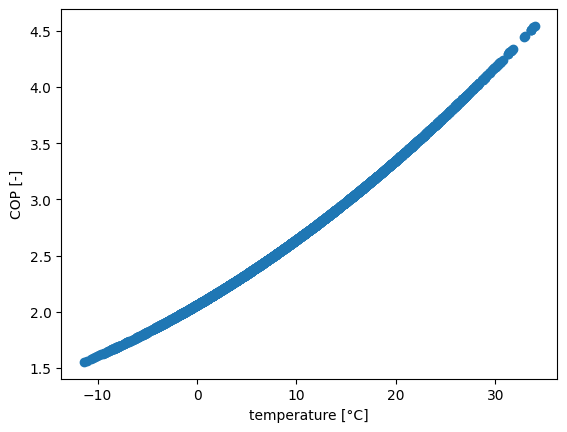

In [23]:
plt.scatter(temp, cop(temp))
plt.xlabel("temperature [°C]")
plt.ylabel("COP [-]")

Once we have calculated the heat pump coefficient of performance, we can add the heat pump to the network as a `Link`. We use the parameter `efficiency` to incorporate the COP.

In [24]:
n.add(
    "Link",
    "heat pump",
    carrier="heat pump",
    bus0="electricity",
    bus1="heat",
    efficiency=cop(temp),
    p_nom_extendable=True,
    capital_cost=annuity(0.05, 18) * 280_000,  # €/MWe/a
);

Let's also add a resistive heater as backup technology:

In [25]:
n.add(
    "Link",
    "resistive heater",
    carrier="resistive heater",
    bus0="electricity",
    bus1="heat",
    efficiency=0.9,
    capital_cost=annuity(0.05, 20) * 120_000,  # €/MWe/a
    p_nom_extendable=True,
);

In [26]:
n.add(
    "Carrier",
    ["heat", "heat demand", "heat pump", "resistive heater"],
    color=["firebrick", "firebrick", "lime", "khaki"],
);

## Combined Heat-and-Power (CHP)

In the following, we are going to add gas-fired combined heat-and-power plants (CHPs). Today, these would use fossil gas, but in the example below we assume imported green methane or methanol with relatively high marginal costs. Since, in that case, we have no other net emission technology, we can remove the CO$_2$ limit.

In [27]:
n.remove("GlobalConstraint", "CO2Limit")

Then, we explicitly represent the energy carrier gas:

In [28]:
n.add("Bus", "gas", carrier="gas");

And add a `Store` of gas, which can be depleted (up to 100 TWh) with fuel costs of 180 €/MWh.

In [29]:
n.add(
    "Store",
    "gas storage",
    carrier="gas storage",
    e_initial=100e6,  # MWh
    e_nom=100e6,  # MWh
    bus="gas",
    marginal_cost=150,  # €/MWh_th
);

When we do this, we have to model the OCGT power plant as link which converts gas to electricity, not as generator.

In [30]:
n.remove("Generator", "OCGT")

In [31]:
n.add(
    "Link",
    "OCGT",
    bus0="gas",
    bus1="electricity",
    carrier="OCGT",
    p_nom_extendable=True,
    capital_cost=annuity(0.07, 25) * 450_000,  # €/MW_th/a
    efficiency=0.4,
);

Next, we are going to add a combined heat-and-power (CHP) plant with fixed heat-power ratio (i.e. backpressure operation).

PyPSA can automatically handle links have more than one input (`bus0`) and/or output (i.e. `bus1`, `bus2`, `bus3`) with a given efficieny (`efficiency`, `efficiency2`, `efficiency3`).

In [32]:
n.add(
    "Link",
    "CHP",
    bus0="gas",
    bus1="electricity",
    bus2="heat",
    carrier="CHP",
    p_nom_extendable=True,
    capital_cost=annuity(0.07, 25) * 600_000,
    efficiency=0.4,
    efficiency2=0.4,
);

And we should not forget to add the carriers for plotting:

In [33]:
n.add("Carrier", ["gas", "gas storage", "CHP"], color=["peru", "tan", "sienna"]);

Now, let's optimize the current status of model:

In [ ]:
n.optimize(solver_name=SOLVER, log_to_console=False)

INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 11/11 [00:00<00:00, 137.74it/s]
INFO:linopy.io: Writing time: 0.62s


Running HiGHS 1.11.0 (git hash: 364c83a): Copyright (c) 2025 HiGHS under MIT licence terms


Now, let's optimize the current status of model:

The objective cost in bn€/a:

In [ ]:
n.objective / 1e9

The heat energy balance (positive is supply, negative is consumption):

In [ ]:
n.statistics.energy_balance(bus_carrier="heat").div(1e6).round(1)

In [ ]:
n.statistics.energy_balance(bus_carrier="electricity").sort_values().div(1e6).round(1)

The heat energy balance as a time series:

In [ ]:
n.statistics.energy_balance.iplot.area(bus_carrier="heat")

In [ ]:
n.statistics.energy_balance.iplot.area(bus_carrier="electricity")

## Long-duration heat storage

One technology of particular interest in district heating systems with large shares of renewables is long-duration thermal energy storage.

In the following, we are going to introduce a heat storage with investment cost of approximately 3 €/kWh.
The energy is not perfectly stored in water tanks. There are standing losses.
The decay of thermal energy in the heat storage is modelled through the function $1 - e^{-\frac{1}{24\tau}}$, where $\tau$ is assumed to be 180 days.
We want to see how that influences the optimal design decisions in the heating sector.

In [ ]:
n.add(
    "Store",
    "heat storage",
    bus="heat",
    carrier="heat storage",
    capital_cost=300,  # roughly annuity of 3 €/kWh/a
    standing_loss=1 - np.exp(-1 / 24 / 180),
    e_nom_extendable=True,
);

In [ ]:
n.add("Carrier", "heat storage", color="teal");

In [ ]:
n.optimize(solver_name=SOLVER, log_to_console=False)

The objective cost (in bn€/a) was reduced!

In [ ]:
n.objective / 1e9

The heat energy balance shows the additional losses of the heat storage and the added supply:

In [ ]:
n.statistics.energy_balance(bus_carrier="heat").div(1e6).round(1)

In [ ]:
n.statistics.energy_balance(bus_carrier="electricity").div(1e6).round(1)

The heat and electricity energy balance as a time series:

In [ ]:
n.statistics.energy_balance.iplot.area(bus_carrier="heat")

In [ ]:
n.statistics.energy_balance.iplot.area(bus_carrier="electricity")

The different storage state of charge time series:

In [ ]:
n.stores_t.e.drop("gas storage", axis=1).plot()

And it can tell you statistics about the capital expenditures:

In [ ]:
n.statistics.capex.iplot()

And it can tell you statistics about the operational expenditures:

In [ ]:
n.statistics.opex.iplot()

## Electric Vehicles

To model electric vehicles, we first create another bus for the electric vehicles.

In [ ]:
n.add("Bus", "EV", carrier="EV");

Then, we can attach the electricity consumption of electric vehicles to this bus:

In [ ]:
url = "https://tubcloud.tu-berlin.de/s/9r5bMSbzzQiqG7H/download/electric-vehicle-profile-example.csv"
p_set = pd.read_csv(url, index_col=0, parse_dates=True).squeeze()
p_set = p_set.resample("3h").mean().interpolate()
p_set.index = p_set.index.shift(365 * 4 + 1, freq="D")
p_set = p_set.reindex(n.snapshots).ffill()
p_set.loc["2019-01-01":"2019-01-07"].div(1e3).plot()

In [ ]:
n.add("Load", "EV demand", bus="EV", carrier="EV demand", p_set=p_set);

The electric vehicles can only be charged when they are plugged-in. Below we load an availability profile
telling us what share of electric vehicles is plugged-in **at home** -- we only assume home charging in this example.

In [ ]:
url = "https://tubcloud.tu-berlin.de/s/E3PBWPfYaWwCq7a/download/electric-vehicle-availability-example.csv"
available = pd.read_csv(url, index_col=0, parse_dates=True).squeeze()
available = available.resample("3h").mean().interpolate()
available.index = available.index.shift(365 * 4 + 1, freq="D")
available = available.reindex(n.snapshots).ffill()
available.loc["2019-01-01":"2019-01-07"].div(1e3).plot()

Then, we can add a link for the electric vehicle charger using assumption about the number of EVs and their charging rates.

In [ ]:
number_cars = 40e6  #  number of EV cars
bev_charger_rate = 0.011  # 3-phase EV charger with 11 kW
p_nom = number_cars * bev_charger_rate

In [ ]:
n.add(
    "Link",
    "EV charger",
    bus0="electricity",
    bus1="EV",
    p_nom=p_nom,
    carrier="EV charger",
    p_max_pu=available,
    efficiency=0.9,
);

We can also allow vehicle-to-grid operation (i.e. electric vehicles inject power into the grid):

In [ ]:
n.add(
    "Link",
    "V2G",
    bus0="EV",
    bus1="electricity",
    p_nom=p_nom,
    carrier="V2G",
    p_max_pu=available,
    efficiency=0.9,
);

The demand-side management potential we model as a store. This is not unlike a battery storage, but we impose additional constraints on when the store needs to be charged to a certain level (e.g. 75% full every morning at 6 o'clock).

In [ ]:
bev_energy = 0.05  # average battery size of EV in MWh
bev_dsm_participants = 0.5  # share of cars that do smart charging

e_nom = number_cars * bev_energy * bev_dsm_participants

In [ ]:
requirement = pd.Series(0., index=n.snapshots)
requirement.where(requirement.index.hour != 6, 0.75, inplace=True)

In [ ]:
n.add(
    "Store",
    "EV battery",
    bus="EV",
    carrier="EV battery",
    e_cyclic=True,  # state of charge at beginning = state of charge at the end
    e_nom=e_nom,
    e_min_pu=requirement,
);

In [ ]:
n.add(
    "Carrier",
    ["EV", "EV demand", "EV charger", "V2G", "EV battery"],
    color=["cadetblue", "cadetblue", "limegreen", "limegreen", "teal"],
);

In [ ]:
n.optimize(solver_name=SOLVER, log_to_console=False)

In [ ]:
n.objective / 1e9

In [ ]:
n.statistics.energy_balance(bus_carrier="electricity").div(1e6).round(1)

In [ ]:
n.statistics.energy_balance.iplot.area(bus_carrier="electricity")

In [ ]:
n.statistics.energy_balance.iplot.area(bus_carrier="EV")

## Exercises

Explore how the model reacts to changing assumptions and available technologies. Here are a few inspirations, but choose in any order according to your interests:

- Assume underground hydrogen storage is not geographically available. Increase the cost of hydrogen storage by factor 10. How does the model react? You can alter the costs with `n.stores.loc["StoreName", "capital_cost"] *= 10`.
- Add a ground-sourced heat pump with a constant COP function of 3.5 but double the investment costs. Would this technology get built? How low would the costs need to be? You can add the technology with `n.add("Link", "ground-sourced heat pump", bus0=..., bus1=..., efficiency=..., capital_cost=...)`.
- Limit green gas imports to 10 TWh or even zero. What does the model do in periods with persistent low wind and solar feed-in but high heating demand? You can alter the initial filling level of the gas store with `n.stores.loc["gas storage", "e_initial"] = 10e6`.